# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from math import log

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.metrics.cluster import v_measure_score

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

# Loading data & preprocessing

In [3]:
path_to_colloid_data = './../data/colloidal_parameters.xlsx'

In [4]:
data = pd.read_excel(path_to_colloid_data)

data.head(3)

,Шифр,PDI,"dсредний, нм","Z, мВ"
0,1,0.496,1417.0,-8.2
1,2,0.301,352.9,-28.0
2,3,0.916,3286.3,-33.5


In [5]:
columns = {
    'Шифр': 'id',
    'PDI': '$PDI$',
    'dсредний, нм': '$d_{av}, nm$',
    'Z, мВ': '$Z, mV$'
}

initial_data = data.rename(columns=columns)
initial_data.index = initial_data['id']
initial_data.drop(columns=['id'], inplace=True)

initial_data.head(3)

,$PDI$,"$d_{av}, nm$","$Z, mV$"
id,,,
1,0.496,1417.0,-8.2
2,0.301,352.9,-28.0
3,0.916,3286.3,-33.5


In [6]:
scaled_data = initial_data.copy()
columns_to_scaling = initial_data.columns[1:]

scaler = MinMaxScaler()
scaled_data[columns_to_scaling] = scaler.fit_transform(initial_data[columns_to_scaling])

columns = {
    '$PDI$': '$PDI_{n}$',
    '$d_{av}, nm$': '$d_{av, n}$',
    '$Z, mV$': '$Z_{n}$'
}

scaled_data = scaled_data.rename(columns=columns)

scaled_data.head(3)

,$PDI_{n}$,"$d_{av, n}$",$Z_{n}$
id,,,
1,0.496,0.290777,1.000000
2,0.301,0.018524,0.333333
3,0.916,0.769042,0.148148


In [7]:
samples_preparation = [
    'MFGO, разб. 1:20',
    'HGO, 0.0116 г в 25 мл H2O',
    'GO, RusGraphene, 2 г в 1000 мл H2O',
    'rGO, RusGraphene, 2 г в 1000 мл H2O',
    'GO, RusGraphene, 2 г в 1000 мл H2O',
    'GO, RusGraphene, 1.00 г в 250 мл H2O',
    'rGO, RusGraphene, 0.20 г в 100 мл H2O',
    'GO, RusGraphene, 1.00 г в 250 мл H2O',
    'GO, USA, 0.1 г в 100 мл H2O',
    'GO, RusGraphene, 2 г в 1000 мл H2O',
    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
    'Образец 8 после диализа 7 дней, H2O, стакан 1 л, замена воды каждые 2 дня',
    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в H2O',
    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М',
    'Образец 10 после диализа 3.5 кДа, конд.',
    'Образец 8 после диализа 3.5 кДа, конд. 7 дней в ЭДТА 0.05 М (повторное использование)',
    'Образец 9 после диализа 14 кДа, конд. 7 дней в ЭДТА 0.05М',
    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М',
    'Образец 9 после диализа 14 кДа 75 мм, конд. 7 дней в ЭДТА 0.05М (повторное использование)',
    'Образец 11 после диализа 2 дня, H2O, 1 кДа',
    'Образец 11 после диализа 5 дней, H2O, 14 кДа 75 мм',
    'Образец 9 после диализа при 25°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
    'Образец 9 после диализа при 45°С 14 кДа, конд. 7 дней в ЭДТА 0.05М',
    'Образец 13 после диализа 0.5 кДа, конд. 7 дней в ЭДТА 0.05М',
    'Образец 30 после диализа 12 дней, 14 кДа, конд. 7 дней в ЭДТА 0.05М'
]

samples_type = [
    '$GO$',
    '$GO$',
    '$GO$',
    '$rGO$',
    '$GO$',
    '$GO$',
    '$rGO$',
    '$GO$',
    '$GO$',
    '$GO$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$rGO$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$',
    '$GO_{d}$'
]

samples_class = [0 if el == '$rGO$' else 1 if el == '$GO$' else 2 for el in samples_type]

In [8]:
samples_description = pd.DataFrame(
    {
        'Description': samples_preparation,
        'Type': samples_type,
        'Class': samples_class
    }
)

samples_description.index = scaled_data.index

# Mapping column 'Type'
type_dict = {
    '$rGO$': '$вОГ$',
    '$GO$': '$ОГ$',
    '$GO_{d}$': '$ОГ_{диализ}$',
}

samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

samples_description.head(3)

,Description,Type,Class
id,,,
1,"MFGO, разб. 1:20",$ОГ$,1
2,"HGO, 0.0116 г в 25 мл H2O",$ОГ$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$ОГ$,1


In [9]:
scaled_data = pd.concat([scaled_data, samples_description], axis=1)

scaled_data['Class'] = scaled_data['Class'].astype('int')

scaled_data.head(3)

,$PDI_{n}$,"$d_{av, n}$",$Z_{n}$,Description,Type,Class
id,,,,,,
1,0.496,0.290777,1.000000,"MFGO, разб. 1:20",$ОГ$,1
2,0.301,0.018524,0.333333,"HGO, 0.0116 г в 25 мл H2O",$ОГ$,1
3,0.916,0.769042,0.148148,"GO, RusGraphene, 2 г в 1000 мл H2O",$ОГ$,1


# Feature Engineering

In [10]:
base_features = initial_data.copy().astype(float)

In [11]:
dict_initial_raw = dict(zip(base_features.columns, ['PDI', 'd_{av}', 'Z']))

In [12]:
dict_columns = dict(zip(base_features.columns, ['$PDI_{n}$', '$d_{av, n}$', '$Z_{n}$']))
engineered_data = base_features.copy().rename(columns=dict_columns)

## Combining features as a *quotient of division*

In [13]:
for i, feature1 in enumerate(base_features.columns):
    feature1_raw = dict_initial_raw[feature1]
    
    for j, feature2 in enumerate(base_features.columns):
        if j <= i:
            continue
        else:
            feature2_raw = dict_initial_raw[feature2]
            new_feature_name = r'$(\frac{' + feature1_raw + '}{' + feature2_raw + '})_{n}$'
            new_feature_value = base_features[feature1] / base_features[feature2]

            engineered_data[new_feature_name] = new_feature_value

## Raising features to power *n* and –*n*

In [14]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$({feature1_raw}^' + '{' + f'{-1}' + '})_{n}$'
    new_feature_value = base_features[feature1] ** (-1)
    engineered_data[new_feature_name] = new_feature_value

    for n in range(2, 6):
        new_feature_name = f'$({feature1_raw}^' + f'{n}' + ')_{n}$'
        new_feature_value = base_features[feature1] ** (n)
        engineered_data[new_feature_name] = new_feature_value

        new_feature_name = f'$({feature1_raw}^' + '{' + f'{-n}' + '})_{n}$'
        new_feature_value = base_features[feature1] ** (-n)
        engineered_data[new_feature_name] = new_feature_value

## *Logarithm* of features

In [15]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$(ln|{feature1_raw}|' + ')_{n}$'
    new_feature_value = np.log(np.abs(base_features[feature1]))
    engineered_data[new_feature_name] = new_feature_value

## Scaling features

In [16]:
columns = engineered_data.columns
indexes = engineered_data.index

scaler = MinMaxScaler()

engineered_data = pd.DataFrame(scaler.fit_transform(engineered_data), columns=columns, index=indexes)

In [17]:
engineered_data.head(3)

,$PDI_{n}$,"$d_{av, n}$",$Z_{n}$,$(\frac{PDI}{d_{av}})_{n}$,$(\frac{PDI}{Z})_{n}$,$(\frac{d_{av}}{Z})_{n}$,$(PDI^{-1})_{n}$,$(PDI^2)_{n}$,$(PDI^{-2})_{n}$,$(PDI^3)_{n}$,$(PDI^{-3})_{n}$,$(PDI^4)_{n}$,$(PDI^{-4})_{n}$,$(PDI^5)_{n}$,$(PDI^{-5})_{n}$,$(d_{av}^{-1})_{n}$,$(d_{av}^2)_{n}$,$(d_{av}^{-2})_{n}$,$(d_{av}^3)_{n}$,$(d_{av}^{-3})_{n}$,$(d_{av}^4)_{n}$,$(d_{av}^{-4})_{n}$,$(d_{av}^5)_{n}$,$(d_{av}^{-5})_{n}$,$(Z^{-1})_{n}$,$(Z^2)_{n}$,$(Z^{-2})_{n}$,$(Z^3)_{n}$,$(Z^{-3})_{n}$,$(Z^4)_{n}$,$(Z^{-4})_{n}$,$(Z^5)_{n}$,$(Z^{-5})_{n}$,$(ln|PDI|)_{n}$,$(ln|d_{av}|)_{n}$,$(ln|Z|)_{n}$
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.317073,0.290777,1.000000,0.107421,0.000000,0.102205,0.414437,0.207648,0.291802,0.127819,0.194922,0.075187,0.125428,0.042884,0.078775,0.140393,0.110436,0.034858,0.038417,0.007459,0.013073,0.001515,0.004428,0.000303,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.448794,0.599089,0.000000
2,0.000000,0.018524,0.333333,0.352948,0.979169,0.977305,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.780119,0.002625,0.630116,0.000298,0.502012,0.000030,0.399128,0.000003,0.317252,0.902381,0.523500,0.040867,0.602873,0.984858,0.296361,0.005176,0.780283,0.998319,0.000000,0.084927,0.802232
3,1.000000,0.769042,0.148148,0.072610,0.652504,0.510288,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.019713,0.613719,0.002814,0.482671,0.000322,0.378768,0.000033,0.297155,0.000003,0.963737,0.770547,0.013748,0.312581,0.995416,0.609555,0.001402,0.460673,0.999595,1.000000,0.910232,0.919386


In [18]:
engineered_data.shape

(25, 36)

# Clustering & Feature Anslysis

## Class for clustering

In [19]:
class ClusterAnalysis2D():
    def __init__(self, target=None, hue=None):
        if target is not None:
            self.target = target
        if hue is not None:
            self.hue = hue

    def fit_transform_kmeans(self, train_data, n_clusters, random_state=42):
        estimator = KMeans(n_clusters=n_clusters,
                           init='k-means++',
                           random_state=42)
        
        estimator.fit(train_data)       
        
        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator

        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Predictions'])
        self.predictions = predictions['Predictions']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)

    def get_homogeneity(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            homogeneity = homogeneity_score(labels_true=target, labels_pred=predictions)
        return homogeneity

    def get_completeness(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            completeness = completeness_score(labels_true=target, labels_pred=predictions)
        return completeness

    def get_v_measure(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            v_measure = v_measure_score(labels_true=target, labels_pred=predictions)
        return v_measure

    def get_silhouette_score(self):
        train_data = self.train_data
        estimator = self.estimator
        if self.n_clusters >=2:
            silhouette = silhouette_score(train_data, estimator.labels_)
        else:
            silhouette = None
        return silhouette

    def get_wccs(self):
        estimator = self.estimator
        wcss = estimator.inertia_
        return wcss

    def optimize_n_clusters(self, train_data, metric='silhouette', max_n_clusters=None):
        if max_n_clusters == None:
            max_n_clusters = train_data.shape[0] // 2
        n_clusters_arr = range(1, max_n_clusters+1)

        metric_values = []
        for n_clusters in n_clusters_arr:
            self.fit_transform_kmeans(train_data=train_data, n_clusters=n_clusters)
            if metric == 'silhouette':
                value = self.get_silhouette_score()
            elif metric == 'v_measure':
                value = self.get_v_measure()
            metric_values.append(value)
        
        opt_n_clusters = n_clusters_arr[np.argmax(metric_values)]
        return opt_n_clusters

    def get_clustering_visualization(self, figsize=(11, 7.5), markersize=14, palette='Dark2', color=None, fontsize=None, print_point_labels=False, path_to_save=None, dpi=300):
        # preparing data
        vis_data = self.train_data_predictions
        x_col_name = vis_data.columns[0]
        y_col_name = vis_data.columns[1]
        predictions_col = vis_data.columns[2]

        hue_col = self.hue
        opt_n_clusters = self.n_clusters

        x_cluster_centers = self.estimator.cluster_centers_[:, 0]
        y_cluster_centers = self.estimator.cluster_centers_[:, 1]  

        # matplotlib & seaborn code
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)

        ax = fig.gca()
        ax.grid(True)
        ax.tick_params(direction='in')

        # selecting palette or color
        if color is not None:
            hue_col = None
            palette = None
        
        # scatter plot of data
        scatter = sns.scatterplot(
            data=vis_data,
            x=x_col_name,
            y=y_col_name,
            hue=hue_col,
            palette=palette,
            color=color,
            s=markersize,
            # ax=ax
        )
        
        # visualizing lines between point in cluster centroid
        for clust_number in range(opt_n_clusters):
            temp_df = vis_data.loc[vis_data[predictions_col] == clust_number]
            temp_x = temp_df.iloc[:, 0].to_numpy()
            temp_y = temp_df.iloc[:, 1].to_numpy()

            x_clust_center = x_cluster_centers[clust_number]
            y_clust_center = y_cluster_centers[clust_number]
            
            x_point_cluster = [[x, x_clust_center] for x in temp_x]
            y_point_cluster = [[y, y_clust_center] for y in temp_y]

            ax.scatter(x=x_clust_center,
                       y=y_clust_center,
                       marker='D',
                       s=markersize // 4,
                       color='black')
            
            for x_x_cl, y_y_cl in zip(x_point_cluster, y_point_cluster):
                ax.plot(x_x_cl,
                        y_y_cl,
                        '--',
                        linewidth=1.5,
                        color='black')

        # Add text annotations for each point
        if print_point_labels:
            for i, (x, y) in enumerate(zip(vis_data[x_col_name], vis_data[y_col_name])):
                ax.text(x, y, str(vis_data.index[i]), fontweight='normal', fontsize=8, ha='center', va='center', color='white')

        if fontsize is not None:
            ax.set_xlabel(x_col_name, fontsize=fontsize, fontstyle='italic')
            ax.set_ylabel(y_col_name, fontsize=fontsize, fontstyle='italic')

        if hue_col is not None:
            legend = ax.legend(loc='best', fontsize=fontsize, markerscale=0.7)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)

        plt.show()

## Enumerating all feature pairs and calculating quality metrics (QM)

In [20]:
%%time

columns = engineered_data.columns
n_columns = len(columns)

target = samples_description['Class']#.to_numpy()
types = samples_description['Type']#.to_numpy()

qm_dict = {
    'Feature_1': [],
    'Feature_2': [],
    'Feature_Pair': [],
    'Homogeneity': [],
    'Completeness': [],
    'V_measure': []
}


for i in tqdm(range(n_columns)):
    for j in range(i, n_columns):
        feature_pair_name = f'[{columns[i]}; {columns[j]}]'
        feature_name1 = columns[i]
        feature_name2 = columns[j]
        feature_pair = engineered_data.loc[:, [feature_name1, feature_name2]]
        
        analyzer = ClusterAnalysis2D(target=target)
        
        opt_n_clusters = analyzer.optimize_n_clusters(train_data=feature_pair, metric='v_measure')
        
        analyzer.fit_transform_kmeans(train_data=feature_pair, n_clusters=opt_n_clusters)
        
        homogeneity = analyzer.get_homogeneity()
        completeness = analyzer.get_completeness()
        v_measure = analyzer.get_v_measure()

        qm_dict['Feature_1'].append(feature_name1)
        qm_dict['Feature_2'].append(feature_name2)
        qm_dict['Feature_Pair'].append(feature_pair_name)
        qm_dict['Homogeneity'].append(homogeneity)
        qm_dict['Completeness'].append(completeness)
        qm_dict['V_measure'].append(v_measure)

qm_df = pd.DataFrame(qm_dict)

100%|███████████████████████████████████████████| 36/36 [02:03<00:00,  3.44s/it]

CPU times: user 12min 35s, sys: 3min 33s, total: 16min 8s
Wall time: 2min 3s


In [21]:
qm_df.head(3)

,Feature_1,Feature_2,Feature_Pair,Homogeneity,Completeness,V_measure
0,$PDI_{n}$,$PDI_{n}$,[$PDI_{n}$; $PDI_{n}$],0.522169,0.215907,0.305497
1,$PDI_{n}$,"$d_{av, n}$","[$PDI_{n}$; $d_{av, n}$]",0.882486,0.363722,0.515130
2,$PDI_{n}$,$Z_{n}$,[$PDI_{n}$; $Z_{n}$],0.835197,0.351074,0.494349


## Visualization of results

In [22]:
path_to_save = './../results/clustering'

### Barplot of QM

In [23]:
# Transformation df to df with cocolumns ['Feature_Pair', 'Metric', 'Value']
qm_df_vis = pd.DataFrame()

for col in qm_df.columns[3:]:
    temp_df = qm_df.loc[:, ['Feature_1', 'Feature_2', 'Feature_Pair', col]]
    temp_df = temp_df.rename(columns={col: 'Value'})
    temp_df['Metric'] = [col] * temp_df.shape[0]

    qm_df_vis = pd.concat([qm_df_vis, temp_df], axis=0)

qm_df_vis = qm_df_vis.sort_values(by=['Metric', 'Value'], ascending=False)

# Selecting top-5 features by v-measure
top = qm_df_vis['Feature_Pair'][:5]

qm_df_vis_top = qm_df_vis.loc[qm_df_vis['Feature_Pair'].isin(top)]

# Renaming metrics
qm_df_vis_top['Metric'] = qm_df_vis_top['Metric'].apply(lambda x: f'${x.lower().replace("_", "-")}$')

qm_df_vis_top.head(3)

,Feature_1,Feature_2,Feature_Pair,Value,Metric
84,$Z_{n}$,$(d_{av}^{-1})_{n}$,[$Z_{n}$; $(d_{av}^{-1})_{n}$],0.867584,$v-measure$
455,$(d_{av}^{-1})_{n}$,$(ln|Z|)_{n}$,[$(d_{av}^{-1})_{n}$; $(ln|Z|)_{n}$],0.748617,$v-measure$
483,$(d_{av}^{-2})_{n}$,$(Z^{-1})_{n}$,[$(d_{av}^{-2})_{n}$; $(Z^{-1})_{n}$],0.748414,$v-measure$


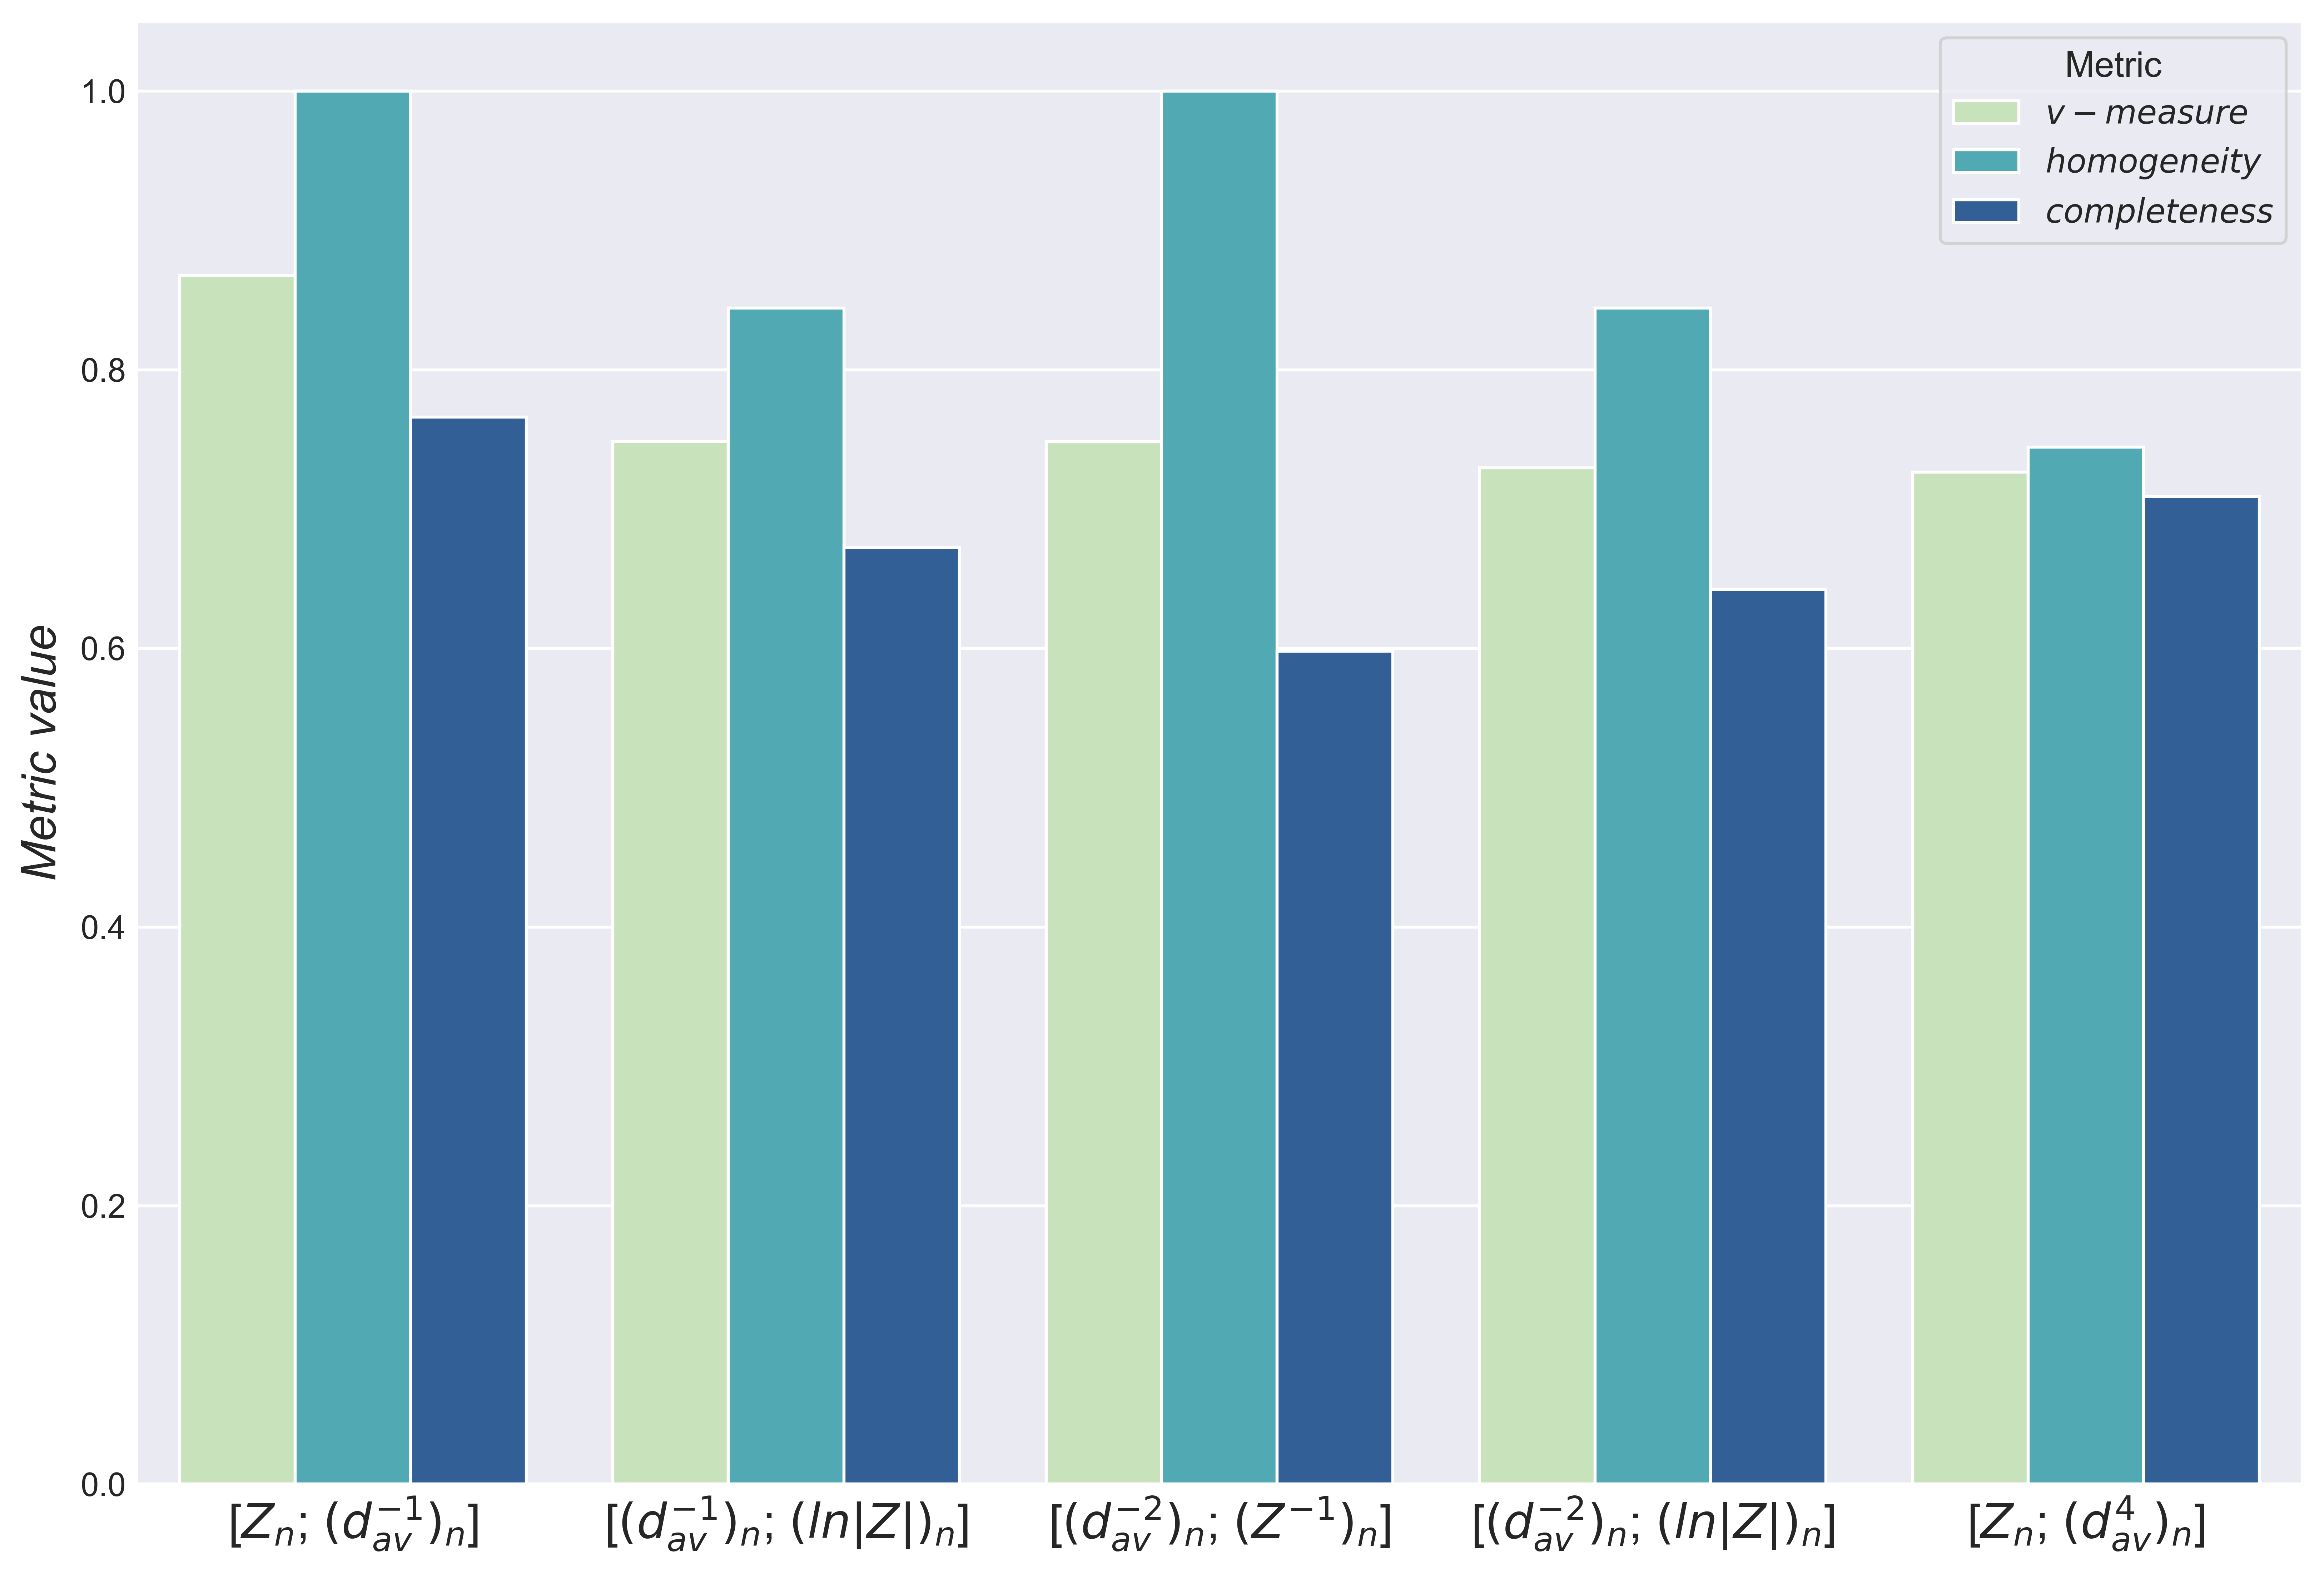

In [24]:
sns.set_theme()

fig = plt.figure(figsize=(11, 7.5), dpi=600, linewidth=1.0)

ax = fig.gca()

ax.grid(True)
ax.tick_params(direction='in')

bar = sns.barplot(data=qm_df_vis_top,
                  x='Feature_Pair',
                  y='Value',
                  hue='Metric',
                  palette='YlGnBu',
                  ax=ax)

ax.set_ylabel('Metric value',
              fontstyle='italic',
              fontsize=16,
              rotation=90,
              labelpad=5)

ax.set_xlabel('')

bar.set_xticklabels(bar.get_xticklabels(), rotation=0, fontsize=16)

plt.tight_layout()

plt.savefig(path_to_save + '/qm_barplot.png', dpi=600)
plt.show()

### Scatterplot in the coodirnares of *top-1* features pair

In [25]:
feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[0], qm_df_vis_top['Feature_2'].tolist()[0]

top1_features_pair_df = engineered_data.loc[:, [feature_1, feature_2]]

top1_features_pair_df.head(3)

,$Z_{n}$,$(d_{av}^{-1})_{n}$
id,,
1,1.000000,0.140393
2,0.333333,0.780119
3,0.148148,0.019713


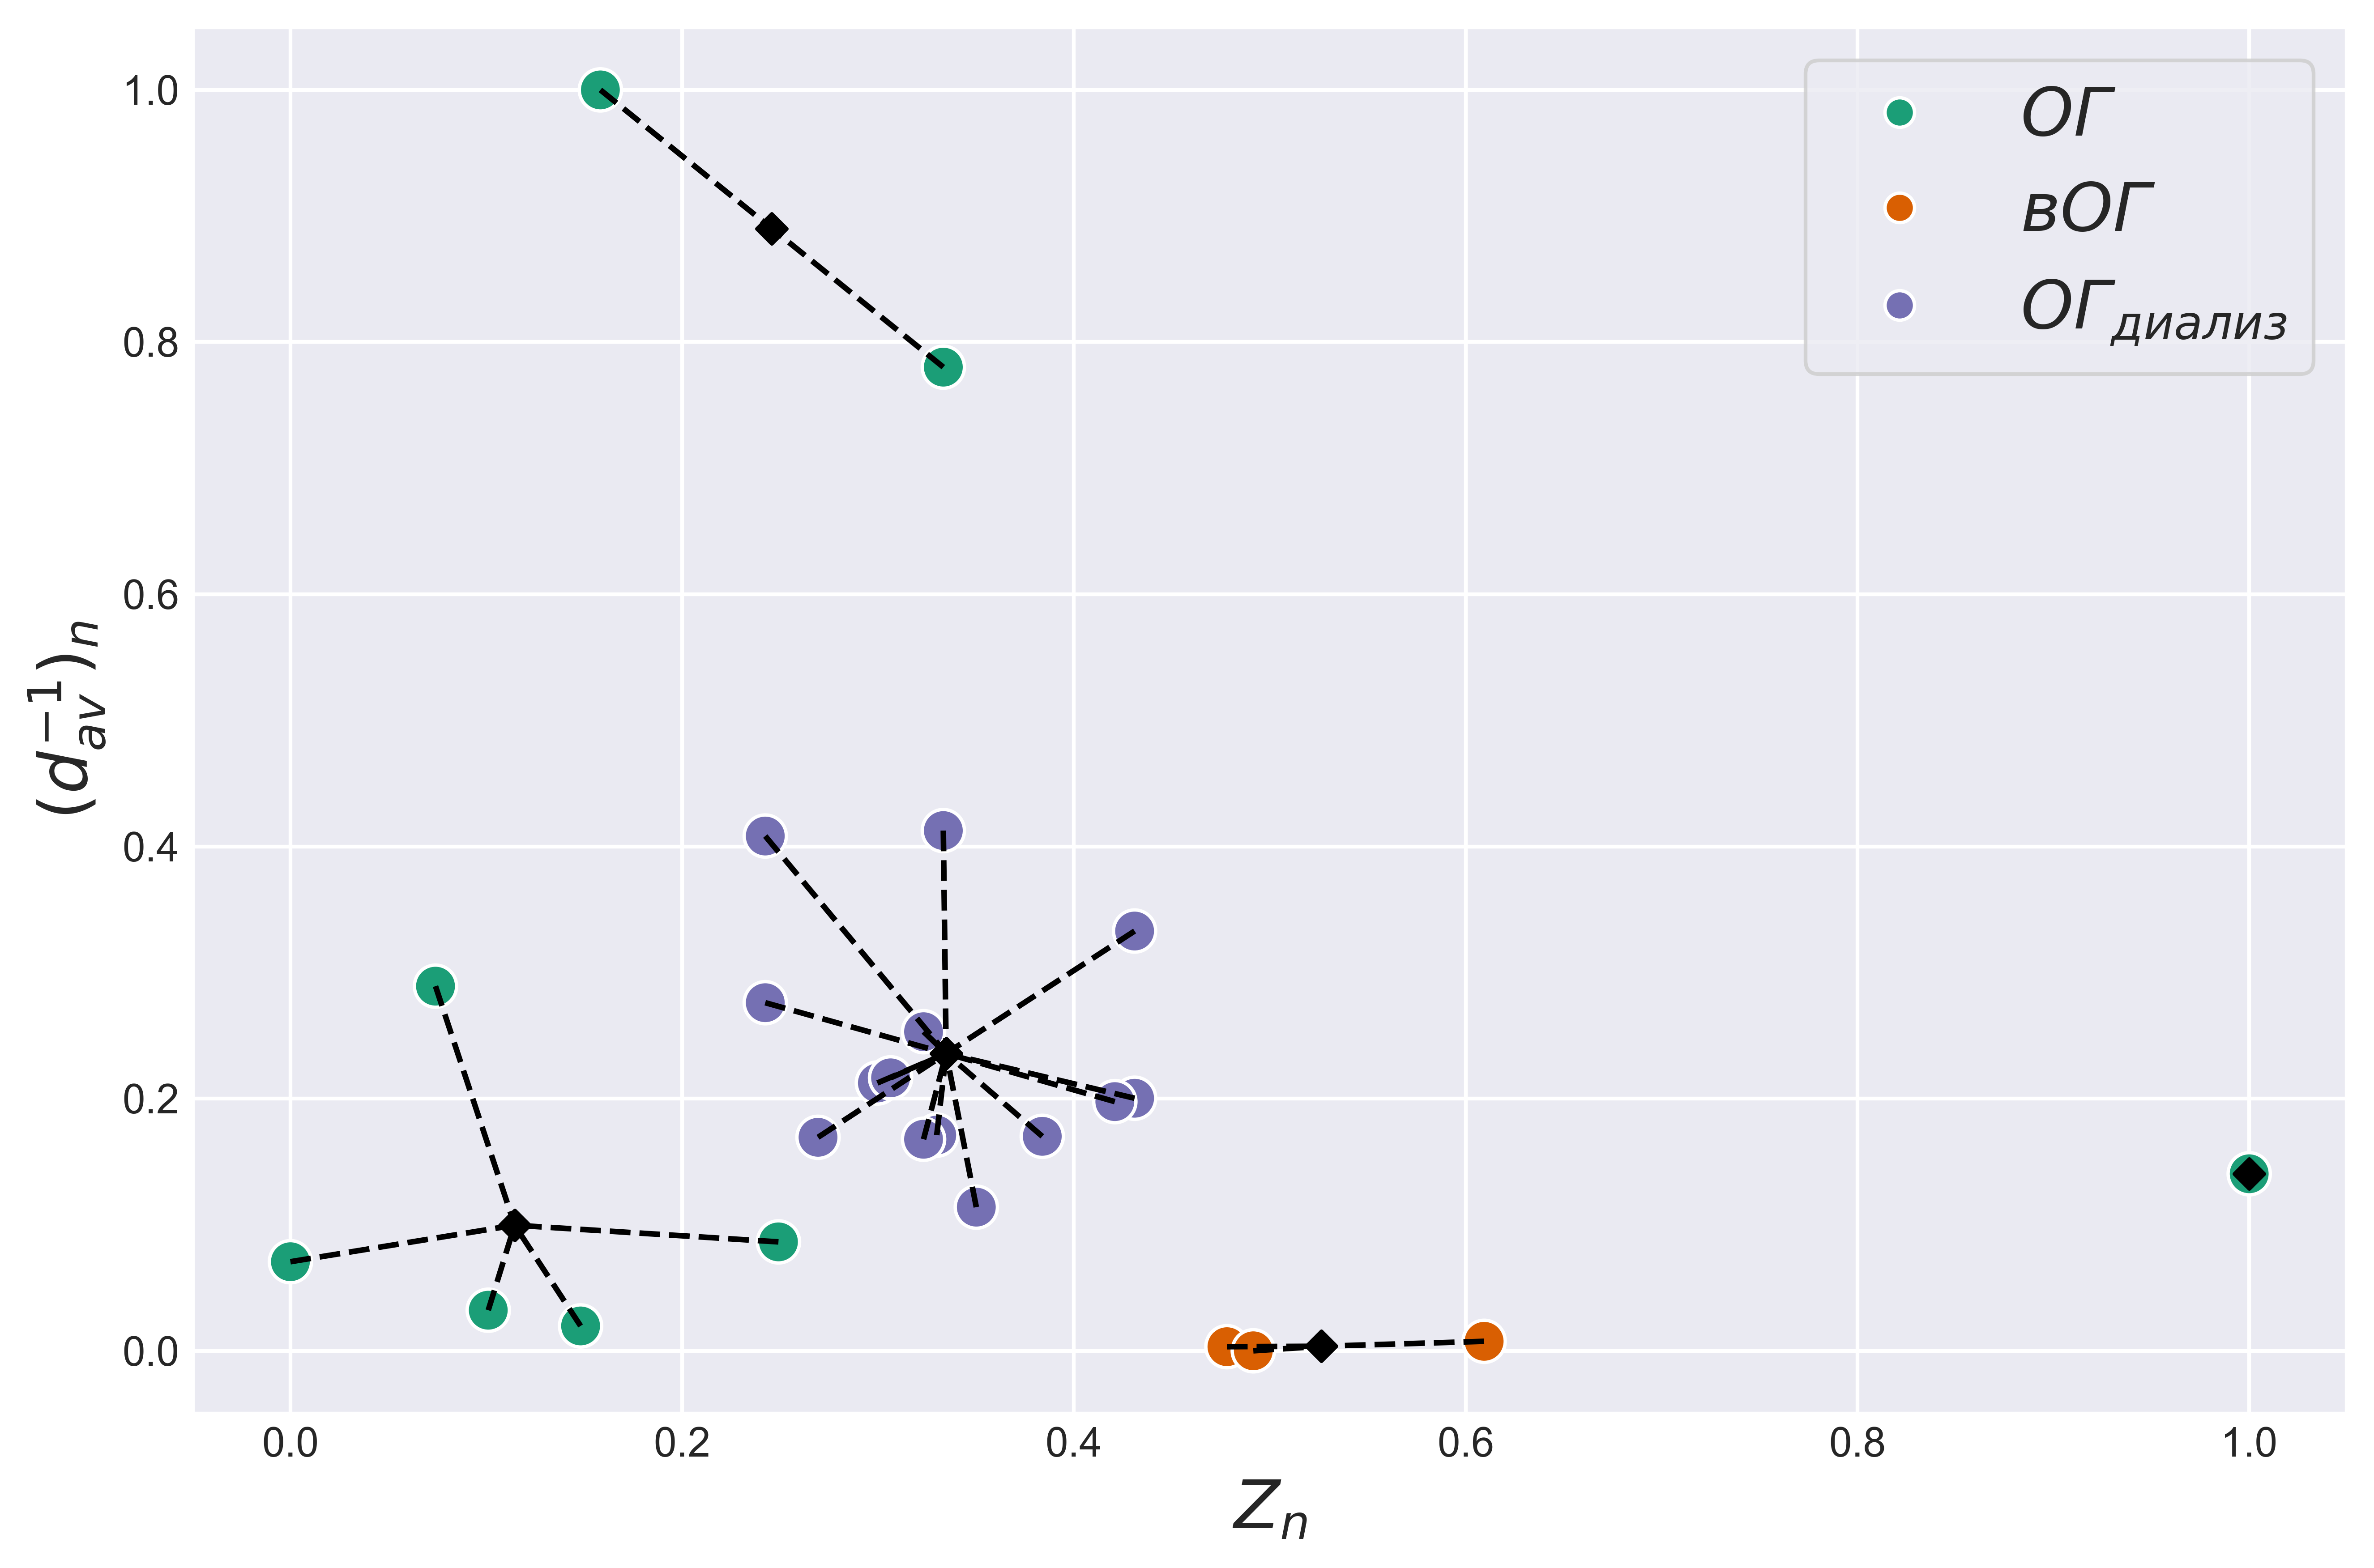

In [26]:
target = samples_description['Class']
hue = samples_description['Type']

analyzer = ClusterAnalysis2D(target=target, hue=hue)

opt_n_cluster = analyzer.optimize_n_clusters(train_data=top1_features_pair_df,
                                             metric='v_measure')

analyzer.fit_transform_kmeans(train_data=top1_features_pair_df,
                              n_clusters=opt_n_cluster)

analyzer.get_clustering_visualization(figsize=(9, 6.0),
                                      markersize=128,
                                      fontsize=18,
                                      print_point_labels=False,
                                      # path_to_save=path_to_save + '/scatterplot_top1.png',
                                      dpi=600)